# Import necessary libraries

In [ ]:
import pandas as pd
import math
import numpy as np
from fbprophet import Prophet
from fbprophet.plot import plot_cross_validation_metric 
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
import matplotlib.pyplot as plt

# Necessary Functions

In [ ]:
# Mean Absolute Error
def mean_absolute_error(y_true, y_pred): 
  return np.round(np.mean(np.abs((y_pred - y_true))),decimals=2)
# Mean Sqaured Error
def mean_squared_error( y_pred,y_true): 
  return np.round(np.mean((y_pred - y_true)**2),decimals=2)
# Root Mean Sqaured Error
def root_mean_squared_error(y_pred,y_true): 
  return np.round(np.sqrt(mean_squared_error(y_pred, y_true)),decimals=2)
# Mean Absolute Percentage Error
def mean_absolute_percentage_error(y_true, y_pred): 
  return np.round(np.mean(np.abs((y_pred - y_true) /np.abs(y_true))) * 100,decimals=2)

# Read the data

Read the input hospital data and then set the index to the 'Date' column.


In [ ]:
# Read the data
Hospital_df = pd.read_csv('ProcessedDataset.csv',parse_dates=True)
# Change the date format
Hospital_df['Date'] = pd.to_datetime(Hospital_df['Date'], format='%d-%m-%Y')
Hospital_df.index = Hospital_df['Date']

# Holidays Data 




*   Pull the hospital data from the input file
*   Aggregate the 3 German States Holiday columns for both School and Public Holidays
* Concatenate both the holidays into holidays dataframe under 'holiday' column name as Prophet model expects a single column holiday.




In [ ]:
#School holidays Aggregation
holidays_S = pd.DataFrame({'ds': Hospital_df["Date"],'holiday': Hospital_df[["S_BW", "S_H","S_RP"]].max(axis=1)})
holidays_S['holiday'] = holidays_S['holiday'].replace({1: 'schoolholiday', 0: 'noholidays'})
holidays_S = holidays_S[holidays_S['holiday'] == 'schoolholiday'] 
#Public holidays Aggregation
holidays_P = pd.DataFrame({'ds': Hospital_df["Date"],'holiday': Hospital_df[["P_BW", "P_H","P_RP"]].max(axis=1)})
holidays_P['holiday'] = holidays_P['holiday'].replace({1: 'publicholiday', 0: 'noholidays'})
holidays_P = holidays_P[holidays_P['holiday'] == 'publicholiday'] 
# Concatenating both holidays
holidays = pd.concat((holidays_S, holidays_P))
# Total Holidays
holidays.shape

(1584, 2)

# Train Test Split

In [ ]:
# Splitting the data into train and test dataframes
Train_df = Hospital_df.loc['2008-01-01':'2012-12-31']
Test_df = Hospital_df.loc['2013-01-01':'2013-01-30']
period = len(Test_df.index)
# Print the shape of test and train data
print(len(Test_df.index))
print(len(Train_df.index))

30
1827


# Prophet Model Preparation

For prophet to work,the model expects the names of these columns to 'ds'(Date) and 'y'(Occupancy) for training and test data

In [ ]:
Train_df=Train_df.rename(columns={'Date':'ds', 'Occupancy':'y'})
Test_df=Test_df.rename(columns={'Date':'ds', 'Occupancy':'y'})

# Plots 

Plot the Training data

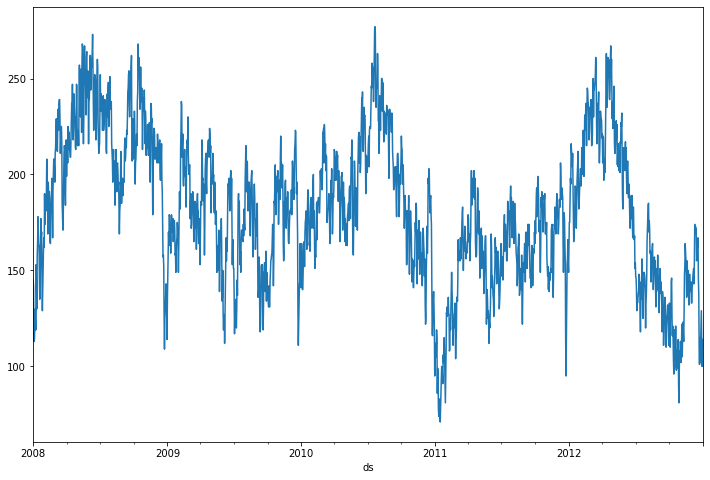

In [ ]:
Train_df.set_index('ds').y.plot(figsize=(12,8))

### Plotting the Whole data

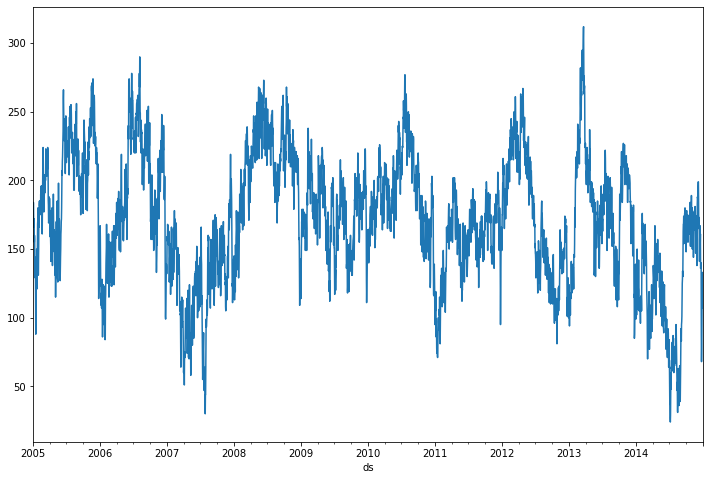

In [ ]:
Full_data = Hospital_df.loc['2005-01-01':'2014-12-31']
Full_data=Full_data.rename(columns={'Date':'ds', 'Occupancy':'y'})
Full_data.set_index('ds').y.plot(figsize=(12,8))

# Stationary Checks and code to make the data stationary

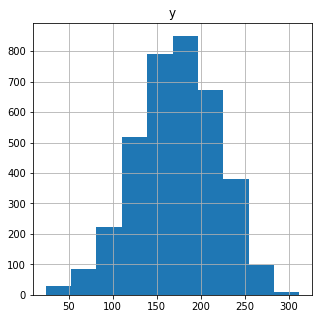

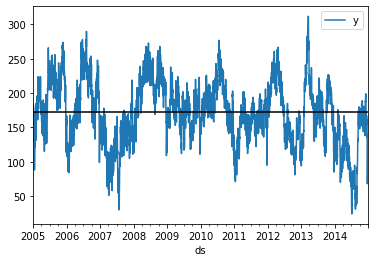

In [ ]:
#To check if the data is stationary
Full_data = Full_data[['ds','y']]
#Plotting the histogram for check for normal distribution
Full_data.hist(figsize=(5,5))
#Adding the horizontal line across the 'y' 
Full_data.set_index('ds', inplace=True)
Full_data.plot()
plt.axhline(Full_data['y'].mean(),c='black')
plt.show()

In [ ]:
# #Making the data Stationary
# Full_data['y'] = Full_data['y'] - Full_data['y'].shift(1)
# Full_data.plot()

When working with time-series data, its good to take a look at the data to determine if trends exist, whether it is stationary, has any outliers and/or any other anamolies. 

# Running Prophet Model


In [ ]:
model = Prophet(holidays=holidays)
model.fit(Train_df);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
#Holiday names
model.train_holiday_names

# Forecasting:

Make a new dataframe containing the dates to be predicted for the future


periods --> number of days into the future

include_history --> True or False to include the training data

freq --> days,hours, months 


In [ ]:
#test
future = model.make_future_dataframe(periods=period,include_history = False,freq='D') 
#train
future_t = model.make_future_dataframe(periods=0,include_history = True,freq='D') 

To forecast this future data, we need to run it through Prophet's model.

In [ ]:
forecast = model.predict(future)
forecast_t = model.predict(future_t)
print(len(forecast.index))

30


Fields needed in the Forecast data :

yhat - Prediction output

yhat_lower and yhat_upper - confidence intervals for the prediction output

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
25,2013-01-26,98.596808,69.582601,128.502270
26,2013-01-27,105.746662,79.913618,134.214621
27,2013-01-28,111.994142,81.963096,140.149330
28,2013-01-29,113.645452,84.779660,142.597395
29,2013-01-30,114.643998,86.445731,143.898736


In [ ]:
forecast.to_csv(r'forecast_fbprophet.csv')

# Actual vs Predicted Plot

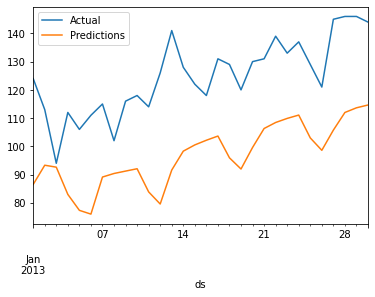

In [ ]:
# A vs P plot
test = Test_df.plot(x='ds',y='y',label='Actual',legend=True)
forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(6,4),ax=test)

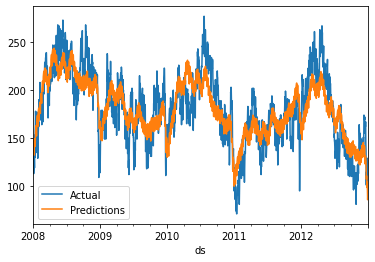

In [ ]:
# A vs P plot on the train data
train = Train_df.plot(x='ds',y='y',label='Actual',legend=True)
forecast_t.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(6,4),ax=train)

In [ ]:
train_dft = Train_df.loc['2012-09-01':'2012-01-31']
fig, ax = plt.subplots(figsize=(8,5))
forecast_t.plot(ax=ax)
Test_df.plot(ax=ax)
train_dft.plot(ax=ax)
plt.xlabel('Date')
plt.ylabel('Occupancy')
ax.legend(["Predictions", "Actual","train"]);

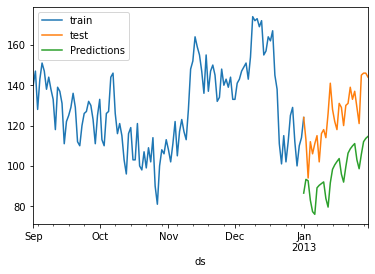

In [ ]:
train_dft = Hospital_df.loc['2012-09-01':'2013-01-01']
# Train_df.loc['2012-09-01':'2012-12-31'] 
train = train_dft.plot(x='Date',y='Occupancy',label='train',legend=True)
test = Test_df.plot(x='ds',y='y',label='test',legend=True,ax=train)
forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(6,4),ax=train)

In [ ]:
Train_df.tail()
Train_df.loc['2012-09-01']
            #  :'2012-01-31']

ds              2012-09-01 00:00:00
Admissions                       45
Discharges                       50
y                               140
Day_of_week                       5
Day_of_year                     245
Week_of_year                     35
Year                           2012
Month_Name                September
Month                             9
P_BW                              0
P_H                               0
P_RP                              0
S_BW                              1
S_H                               0
S_RP                              0
Name: 2012-09-01 00:00:00, dtype: object

# Error Metrics
Calculation of MAPE, MAE and RMSE - Test

In [ ]:
print('Mean absolute percentage error: ',mean_absolute_percentage_error(Test_df['y'].values,forecast['yhat'].values))
print('Mean absolute error: ',mean_absolute_error(Test_df['y'].values,forecast['yhat'].values))
print('Root Mean Square error: ',root_mean_squared_error(forecast['yhat'].values,Test_df['y'].values))

Mean absolute percentage error:  22.18
Mean absolute error:  27.96
Root Mean Square error:  29.41


Calculation of MAPE, MAE and RMSE - Train

In [ ]:
print('Mean absolute percentage error: ',mean_absolute_percentage_error(Train_df['y'].values,forecast_t['yhat'].values))
print('Mean absolute error: ',mean_absolute_error(Train_df['y'].values,forecast_t['yhat'].values))
print('Root Mean Square error: ',root_mean_squared_error(forecast_t['yhat'].values,Train_df['y'].values))

Mean absolute percentage error:  10.54
Mean absolute error:  17.87
Root Mean Square error:  21.97


# plotting last month fit data

In [ ]:
# # O_dft = O_dft[['20120101':'20121231']]
# O_dft = forecast_t[1796:1826]
# train_dft = train[1796:1826]
# ax = train_dft.plot(y='Occupancy',label='Actual',legend=True)
# O_dft.plot(x='Date',y='Occupancy',label='Predictions',legend=True,figsize=(10,4),ax=ax)

# Plotting Prophet results and the compoenents

Prophet has a plotting mechanism called ```plot```.  This plot functionality draws the original data (black dots), the model (blue line) and the error of the forecast (shaded blue area).

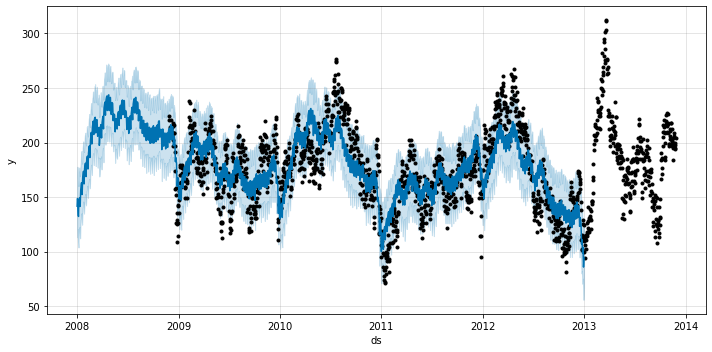

In [ ]:
model.plot(forecast_t,figsize=(10,5)
           );

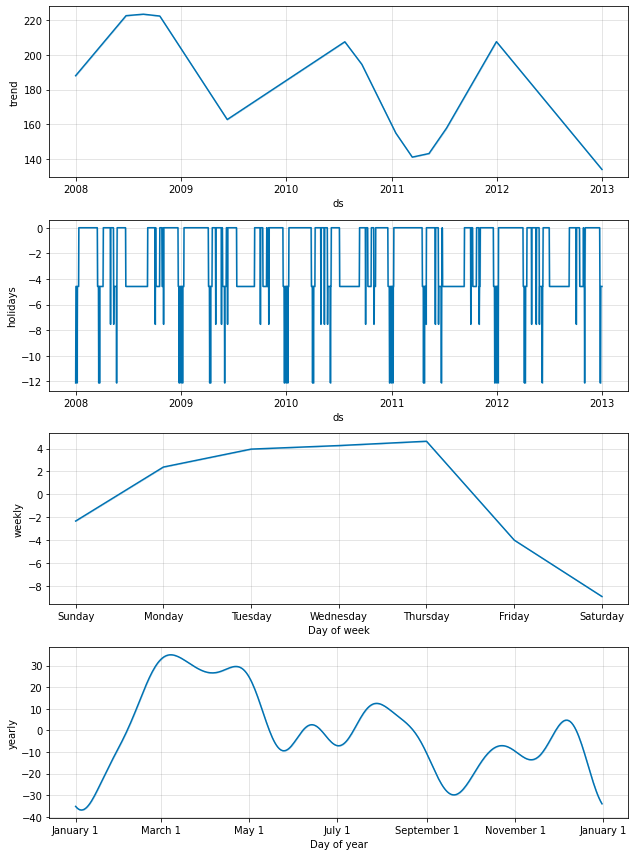

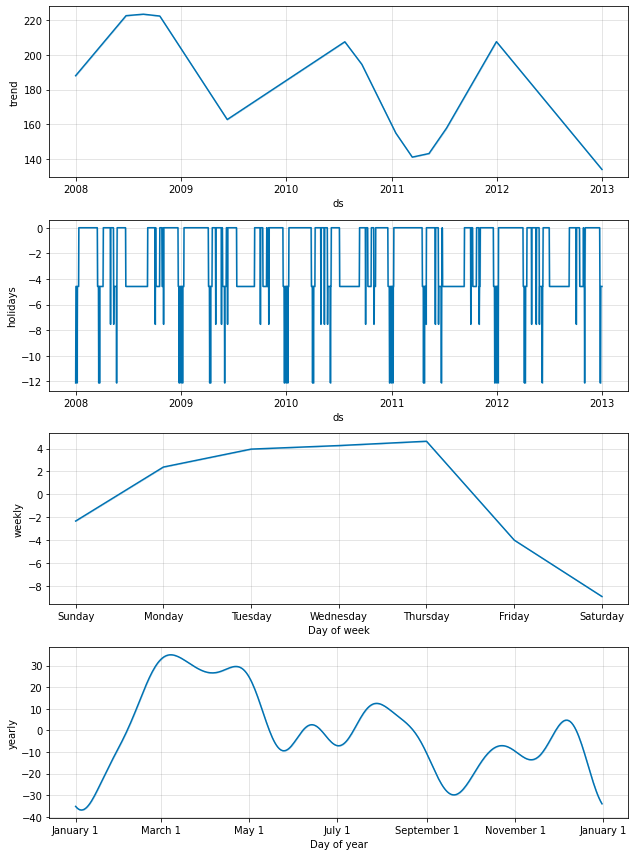

In [ ]:
# Visualize Each Component [Trends,Weekly]
model.plot_components(forecast_t)

# Cross Validation


In [ ]:
# from fbprophet.diagnostics import cross_validation

In [ ]:
# cv = cross_validation(model, period='365 days', horizon = '31 days')

In [ ]:
# cv

In [ ]:
# df_pm = performance_metrics(cv)

In [ ]:
# df_pm.shape

In [ ]:
# df_pm

### Visualising performance metrics

In [ ]:
# fig = plot_cross_validation_metric(cv, metric='mape')

# Testing the for loop - Multiple Training Periods for test data(1-5 years)

In [ ]:
training_time = pd.read_csv('training_time.csv')
# Change the date format
training_time['start'] = pd.to_datetime(training_time['start'], format='%d-%m-%Y')
training_time['end'] = pd.to_datetime(training_time['end'], format='%d-%m-%Y')

Train_df = []
mape = []
mae = []
rmse = []

Test_df = Hospital_df.loc['2013-01-01':'2013-01-30']
Test_df= Test_df.rename(columns={'Date':'ds', 'Occupancy':'y'})
period = len(Test_df.index)

for i,row in training_time.iterrows():
  Train_df = Hospital_df.loc[row['start']:row['end']]
  print(len(Train_df.index))
  Train_df=Train_df.rename(columns={'Date':'ds', 'Occupancy':'y'})
  #prophetmodel
  model = Prophet(holidays=holidays)
  model.fit(Train_df)
  future = model.make_future_dataframe(periods=period,include_history = False,freq='D')
  forecast = model.predict(future)
  mape_eachtraining = mean_absolute_percentage_error(Test_df['y'].values,forecast['yhat'].values)
  rmse_eachtraining = root_mean_squared_error(forecast['yhat'].values,Test_df['y'].values)
  mae_eachtraining = mean_absolute_error(Test_df['y'].values,forecast['yhat'].values)
  print('Mean absolute percentage error: ',mape_eachtraining)
  mape.append(mape_eachtraining)
  rmse.append(rmse_eachtraining)
  mae.append(mae_eachtraining)

training_time['MAPE']= mape
training_time['RMSE']= rmse
training_time['MAE']= mae
training_time['Evaluation_time']= period

FileNotFoundError: ignored

In [ ]:
training_time

# Testing the for loop - Multiple Training Periods for Train data(1-5 years)

In [ ]:
training_time = pd.read_csv('training_Accuracy_time.csv')
# Change the date format
training_time['start'] = pd.to_datetime(training_time['start'], format='%d-%m-%Y')
training_time['end'] = pd.to_datetime(training_time['end'], format='%d-%m-%Y')

Train_df = []
mape = []
mae = []
rmse = []

for i,row in training_time.iterrows():
  Train_df = Hospital_df.loc[row['start']:row['end']]
  print(len(Train_df.index))
  Train_df=Train_df.rename(columns={'Date':'ds', 'Occupancy':'y'})

  #prophetmodel
  model = Prophet(holidays=holidays)
  model.fit(Train_df)
  future = model.make_future_dataframe(periods=0,include_history = True,freq='D')
  forecast_t = model.predict(future)

  mape_eachtraining = mean_absolute_percentage_error(Train_df['y'].values,forecast_t['yhat'].values)
  rmse_eachtraining = root_mean_squared_error(forecast_t['yhat'].values,Train_df['y'].values)
  mae_eachtraining = mean_absolute_error(Train_df['y'].values,forecast_t['yhat'].values)
  print('Mean absolute percentage error: ',mape_eachtraining)
  mape.append(mape_eachtraining)
  rmse.append(rmse_eachtraining)
  mae.append(mae_eachtraining)

training_time['MAPE']= mape
training_time['RMSE']= rmse
training_time['MAE']= mae
training_time['Evaluation_time']= period

In [ ]:
training_time

# Testing the for loop - Multiple Training and Testing Periods(1-5 years)

In [ ]:
training_time = pd.read_csv('training_time.csv')
evaluation_time = pd.read_csv('evaluation_time.csv')
# Change the date format
training_time['start'] = pd.to_datetime(training_time['start'], format='%d-%m-%Y')
training_time['end'] = pd.to_datetime(training_time['end'], format='%d-%m-%Y')

Train_df = []

output = pd.DataFrame()

for i,row in evaluation_time.iterrows():
  
  Test_start = pd.to_datetime('01-01-2013',format='%d-%m-%Y')
  Test_end= Test_start + pd.to_timedelta(row['end'], unit='D')
  print(Test_end)
  Test_df = Hospital_df.loc[Test_start:Test_end]
  Test_df= Test_df.rename(columns={'Date':'ds', 'Occupancy':'y'})
  period = len(Test_df.index)
  training_time = pd.read_csv('training_time.csv')
  training_time['Evaluation_time']= period
  mape = []
  mae = []
  rmse = []

  for i,row in training_time.iterrows():
    Train_df = Hospital_df.loc[row['start']:row['end']]
    print(len(Train_df.index))

    #prophetmodel
    Train_df=Train_df.rename(columns={'Date':'ds', 'Occupancy':'y'})
    Train_df = Train_df[['ds','y']]
    model = Prophet(holidays=holidays)
    model.fit(Train_df)
    future = model.make_future_dataframe(periods=period,include_history = False,freq='D')
    forecast = model.predict(future)

    mape_eachtraining = mean_absolute_percentage_error(Test_df['y'].values,forecast['yhat'].values)
    rmse_eachtraining = root_mean_squared_error(forecast['yhat'].values,Test_df['y'].values)
    mae_eachtraining = mean_absolute_error(Test_df['y'].values,forecast['yhat'].values)
    print('Mean absolute percentage error: ',mape_eachtraining)
    mape.append(mape_eachtraining)
    rmse.append(rmse_eachtraining)
    mae.append(mae_eachtraining)

  training_time['MAPE']= mape
  training_time['RMSE']= rmse
  training_time['MAE']= mae
  training_time['Evaluation_time']= period
  output = output.append(pd.DataFrame(data = training_time), ignore_index=True)

In [ ]:
print('Mean of 3 months predictions for 5 year Train data duration: ',np.mean(output[output['traindata_duration'] == '5 years']['MAPE']))
output

# 12 Validation sets rolling evaluation

In [ ]:
# Initialisation model
Train_Start = pd.to_datetime('01-01-2008',format='%d-%m-%Y')
# replace year only
Train_End = pd.to_datetime('31-12-2012',format='%d-%m-%Y')
print(Train_Start)
print(Train_End)

Test_Start = Train_End + pd.to_timedelta(1, unit='D')
Test_End= Test_Start + pd.to_timedelta(29, unit='D')
print(Test_Start)
print(Test_End)

training_time = pd.DataFrame()
mape = []
mae = []
rmse = []
Train_S =[]
Train_E =[]
Test_S =[]
Test_E =[]

for i in range(0,12):
  print('********************************')
  print(i)
  Train_S.append(Train_Start)
  Train_E.append(Train_End)
  Test_S.append(Test_Start)
  Test_E.append(Test_End)

  # Before Training
  Test_df = Hospital_df.loc[Test_Start:Test_End]
  Test_df= Test_df.rename(columns={'Date':'ds', 'Occupancy':'y'})
  Test_df = Test_df[['ds','y']]
  period = len(Test_df.index)

  Train_df = Hospital_df.loc[Train_Start:Train_End]
  print(len(Train_df.index))
  Train_df=Train_df.rename(columns={'Date':'ds', 'Occupancy':'y'})
  Train_df = Train_df[['ds','y']]

  # Prophetmodel
  model = Prophet(holidays=holidays)
  model.fit(Train_df)
  future = model.make_future_dataframe(periods=period,include_history = False,freq='D')
  forecast = model.predict(future)
  mape_eachtraining = mean_absolute_percentage_error(Test_df['y'].values,forecast['yhat'].values)
  rmse_eachtraining = root_mean_squared_error(forecast['yhat'].values,Test_df['y'].values)
  mae_eachtraining = mean_absolute_error(Test_df['y'].values,forecast['yhat'].values)
  print('Mean absolute percentage error: ',mape_eachtraining)
  mape.append(mape_eachtraining)
  rmse.append(rmse_eachtraining)
  mae.append(mae_eachtraining)

  # After Training
  Train_Start = Train_Start + pd.to_timedelta(30, unit='D')
  Train_End = Train_End + pd.to_timedelta(30, unit='D')
  print(Train_Start)
  print(Train_End)

  Test_Start = Test_Start + pd.to_timedelta(30, unit='D')
  Test_End= Test_End + pd.to_timedelta(30, unit='D')
  print(Test_Start)
  print(Test_End)

training_time['Train_Start']= Train_S
training_time['Train_End']= Train_E
training_time['Test_Start']= Test_S
training_time['Test_End']= Test_E
training_time['MAPE']= mape
training_time['RMSE']= rmse
training_time['MAE']= mae

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2008-01-01 00:00:00
2012-12-31 00:00:00
2013-01-01 00:00:00
2013-01-30 00:00:00
********************************
0
1827


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean absolute percentage error:  22.18
2008-01-31 00:00:00
2013-01-30 00:00:00
2013-01-31 00:00:00
2013-03-01 00:00:00
********************************
1
1827


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean absolute percentage error:  42.12
2008-03-01 00:00:00
2013-03-01 00:00:00
2013-03-02 00:00:00
2013-03-31 00:00:00
********************************
2
1827


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean absolute percentage error:  45.54
2008-03-31 00:00:00
2013-03-31 00:00:00
2013-04-01 00:00:00
2013-04-30 00:00:00
********************************
3
1827


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean absolute percentage error:  11.35
2008-04-30 00:00:00
2013-04-30 00:00:00
2013-05-01 00:00:00
2013-05-30 00:00:00
********************************
4
1827


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean absolute percentage error:  7.06
2008-05-30 00:00:00
2013-05-30 00:00:00
2013-05-31 00:00:00
2013-06-29 00:00:00
********************************
5
1827


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean absolute percentage error:  7.46
2008-06-29 00:00:00
2013-06-29 00:00:00
2013-06-30 00:00:00
2013-07-29 00:00:00
********************************
6
1827


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean absolute percentage error:  9.4
2008-07-29 00:00:00
2013-07-29 00:00:00
2013-07-30 00:00:00
2013-08-28 00:00:00
********************************
7
1827


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean absolute percentage error:  6.64
2008-08-28 00:00:00
2013-08-28 00:00:00
2013-08-29 00:00:00
2013-09-27 00:00:00
********************************
8
1827


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean absolute percentage error:  28.26
2008-09-27 00:00:00
2013-09-27 00:00:00
2013-09-28 00:00:00
2013-10-27 00:00:00
********************************
9
1827


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean absolute percentage error:  16.75
2008-10-27 00:00:00
2013-10-27 00:00:00
2013-10-28 00:00:00
2013-11-26 00:00:00
********************************
10
1827


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean absolute percentage error:  10.31
2008-11-26 00:00:00
2013-11-26 00:00:00
2013-11-27 00:00:00
2013-12-26 00:00:00
********************************
11
1827
Mean absolute percentage error:  28.4
2008-12-26 00:00:00
2013-12-26 00:00:00
2013-12-27 00:00:00
2014-01-25 00:00:00


In [ ]:
print('Average MAPE on 12 Validation Sets:',np.mean(training_time['MAPE']))
training_time.to_csv('Model2.csv')

Average MAPE on 12 Validation Sets: 19.6225


In [ ]:
training_time

,Train_Start,Train_End,Test_Start,Test_End,MAPE,RMSE,MAE
0,2008-01-01,2012-12-31,2013-01-01,2013-01-30,22.18,29.41,27.96
1,2008-01-31,2013-01-30,2013-01-31,2013-03-01,42.12,91.25,89.71
2,2008-03-01,2013-03-01,2013-03-02,2013-03-31,45.54,125.48,122.99
3,2008-03-31,2013-03-31,2013-04-01,2013-04-30,11.35,26.16,24.01
4,2008-04-30,2013-04-30,2013-05-01,2013-05-30,7.06,13.96,11.71
5,2008-05-30,2013-05-30,2013-05-31,2013-06-29,7.46,15.24,12.06
6,2008-06-29,2013-06-29,2013-06-30,2013-07-29,9.40,20.97,17.91
7,2008-07-29,2013-07-29,2013-07-30,2013-08-28,6.64,14.45,11.40
8,2008-08-28,2013-08-28,2013-08-29,2013-09-27,28.26,39.41,36.86
9,2008-09-27,2013-09-27,2013-09-28,2013-10-27,16.75,34.47,31.51
